In [1]:
import pandas as pd
import numpy as np
#import numpy_financial as npf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm import tqdm
import missingno as msno
import seaborn as sns
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import UnivariateSpline
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import warnings
warnings.simplefilter('ignore') # 

In [2]:
annual_performance = pd.read_pickle('annual_performance.pickle')
mortgage_activity = pd.read_pickle('mortgage_activity.pickle')

In [3]:
mortgage_activity['NCF_Bin'] = pd.qcut(mortgage_activity['Real Underwritten Annual NCF Per Unit'],q=10, duplicates='drop')

In [4]:
# Group by 'Loan Number' and compute the NCF change for different values of t
def compute_ncf_change(group, t):
    if len(group) < t + 1:
        return None  # Skip if there are not enough rows for this loan

    # Fetch the values for NCF and the years
    NCF_t = group['Real Annual NCF Per Unit'].iloc[0]
    NCF_t_plus_t = group['Real Annual NCF Per Unit'].iloc[t]
    Year_0 = group['Year'].iloc[0]
    Year_t = group['Year'].iloc[t]
    
    # Calculate the requested formula
    if NCF_t_plus_t + NCF_t != 0:  # Avoid division by zero
        delta_ncf = (NCF_t_plus_t - NCF_t) / (0.5 * (NCF_t_plus_t + NCF_t))
        return pd.Series({'delta_ncf': delta_ncf, 'Year_0': Year_0, f'Year_{t}': Year_t})
    else:
        return pd.Series({'delta_ncf': None, 'Year_0': Year_0, f'Year_{t}': Year_t})

# Initialize an empty DataFrame for merging
ncf_change_results_all = pd.DataFrame()

# Loop through values of t (1, 2, 3, 4)
for t in range(1, 5):
    # Get the first `t+1` years for each loan
    first_years_t = annual_performance.groupby('Loan Number').head(t + 1).sort_values(by=['Loan Number', 'Year'])
    
    # Compute NCF change for each loan and reset index
    ncf_change_results_t = first_years_t.groupby('Loan Number').apply(lambda x: compute_ncf_change(x, t)).reset_index()
    ncf_change_results_t.rename(columns={'delta_ncf': f'delta_ncf_t_{t}'}, inplace=True)
    
    # Merge with mortgage_activity data to get additional columns (if it's the first loop)
    if ncf_change_results_all.empty:
        ncf_change_results_all = ncf_change_results_t.merge(
            mortgage_activity[['Loan Number', 'Underwritten Cap Rate', 'Real Underwritten Annual NCF Per Unit', 'NCF_Bin']],
            on='Loan Number', how='left'
        )
    else:
        # For subsequent loops, drop 'Year_0' from ncf_change_results_t to avoid conflicts
        ncf_change_results_t = ncf_change_results_t.drop(columns=['Year_0'])
        ncf_change_results_all = ncf_change_results_all.merge(
            ncf_change_results_t[['Loan Number', f'delta_ncf_t_{t}', f'Year_{t}']],
            on='Loan Number', how='left'
        )


In [5]:
ncf_change_results_all = ncf_change_results_all[ncf_change_results_all['Year_0'].notnull()]
# Convert Year_0 to Year_5 columns to integers
ncf_change_results_all['Year_0'] = ncf_change_results_all['Year_0'].astype(int)

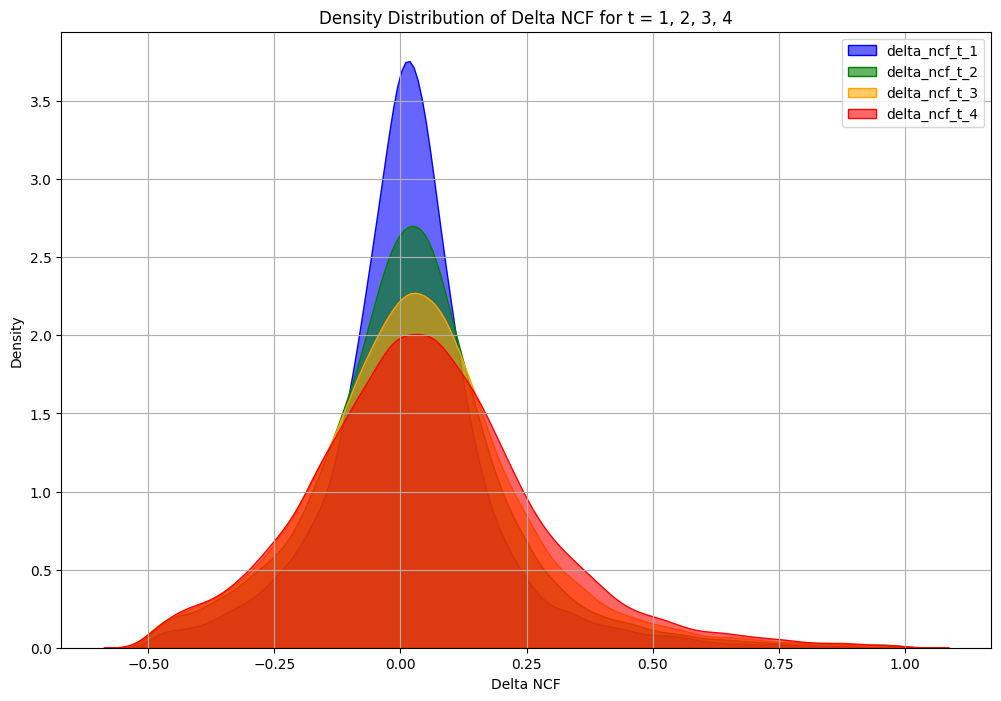

In [6]:
# Filter the data to exclude NaN values for each delta_ncf variable
delta_ncf_t_1 = ncf_change_results_all['delta_ncf_t_1'].dropna()
delta_ncf_t_2 = ncf_change_results_all['delta_ncf_t_2'].dropna()
delta_ncf_t_3 = ncf_change_results_all['delta_ncf_t_3'].dropna()
delta_ncf_t_4 = ncf_change_results_all['delta_ncf_t_4'].dropna()

# Apply the filter for values between -1 and 2
delta_ncf_t_1 = delta_ncf_t_1[(delta_ncf_t_1 >= -0.5) & (delta_ncf_t_1 <= 1)]
delta_ncf_t_2 = delta_ncf_t_2[(delta_ncf_t_2 >= -0.5) & (delta_ncf_t_2 <= 1)]
delta_ncf_t_3 = delta_ncf_t_3[(delta_ncf_t_3 >= -0.5) & (delta_ncf_t_3 <= 1)]
delta_ncf_t_4 = delta_ncf_t_4[(delta_ncf_t_4 >= -0.5) & (delta_ncf_t_4 <= 1)]

# Plot density plots for each t value in a single figure
plt.figure(figsize=(12, 8))

# Density plot for delta_ncf_t_1
sns.kdeplot(delta_ncf_t_1, label='delta_ncf_t_1', color='blue', fill=True, alpha=0.6)

# Density plot for delta_ncf_t_2
sns.kdeplot(delta_ncf_t_2, label='delta_ncf_t_2', color='green', fill=True, alpha=0.6)

# Density plot for delta_ncf_t_3
sns.kdeplot(delta_ncf_t_3, label='delta_ncf_t_3', color='orange', fill=True, alpha=0.6)

# Density plot for delta_ncf_t_4
sns.kdeplot(delta_ncf_t_4, label='delta_ncf_t_4', color='red', fill=True, alpha=0.6)

# Add labels, title, and legend
plt.xlabel('Delta NCF')
plt.ylabel('Density')
plt.title('Density Distribution of Delta NCF for t = 1, 2, 3, 4')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# List of columns to process
columns_to_replace = ['delta_ncf_t_1', 'delta_ncf_t_2', 'delta_ncf_t_3', 'delta_ncf_t_4']

# Loop through each column and replace values outside the range -0.5 to 1 with NaN
for col in columns_to_replace:
    ncf_change_results_all[col] = np.where(
        ncf_change_results_all[col].between(-0.5, 1), 
        ncf_change_results_all[col], 
        np.nan
    )

# Display summary statistics for the modified data
ncf_change_results_all[columns_to_replace].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

# NOTE: Inforce Table 8: Summary Statistics Net Cash Flow Growth ∆t+T

,delta_ncf_t_1,delta_ncf_t_2,delta_ncf_t_3,delta_ncf_t_4
count,46185.0000,39700.0000,32331.0000,26045.0000
mean,0.0162,0.0204,0.0300,0.0445
std,0.1654,0.1976,0.2118,0.2260
min,-0.5000,-0.5000,-0.5000,-0.4999
5%,-0.2505,-0.3049,-0.3142,-0.3166
25%,-0.0642,-0.0892,-0.0978,-0.0998
50%,0.0133,0.0171,0.0243,0.0352
75%,0.0882,0.1187,0.1441,0.1719
95%,0.2842,0.3456,0.3892,0.4313
max,0.9979,0.9985,0.9982,0.9987


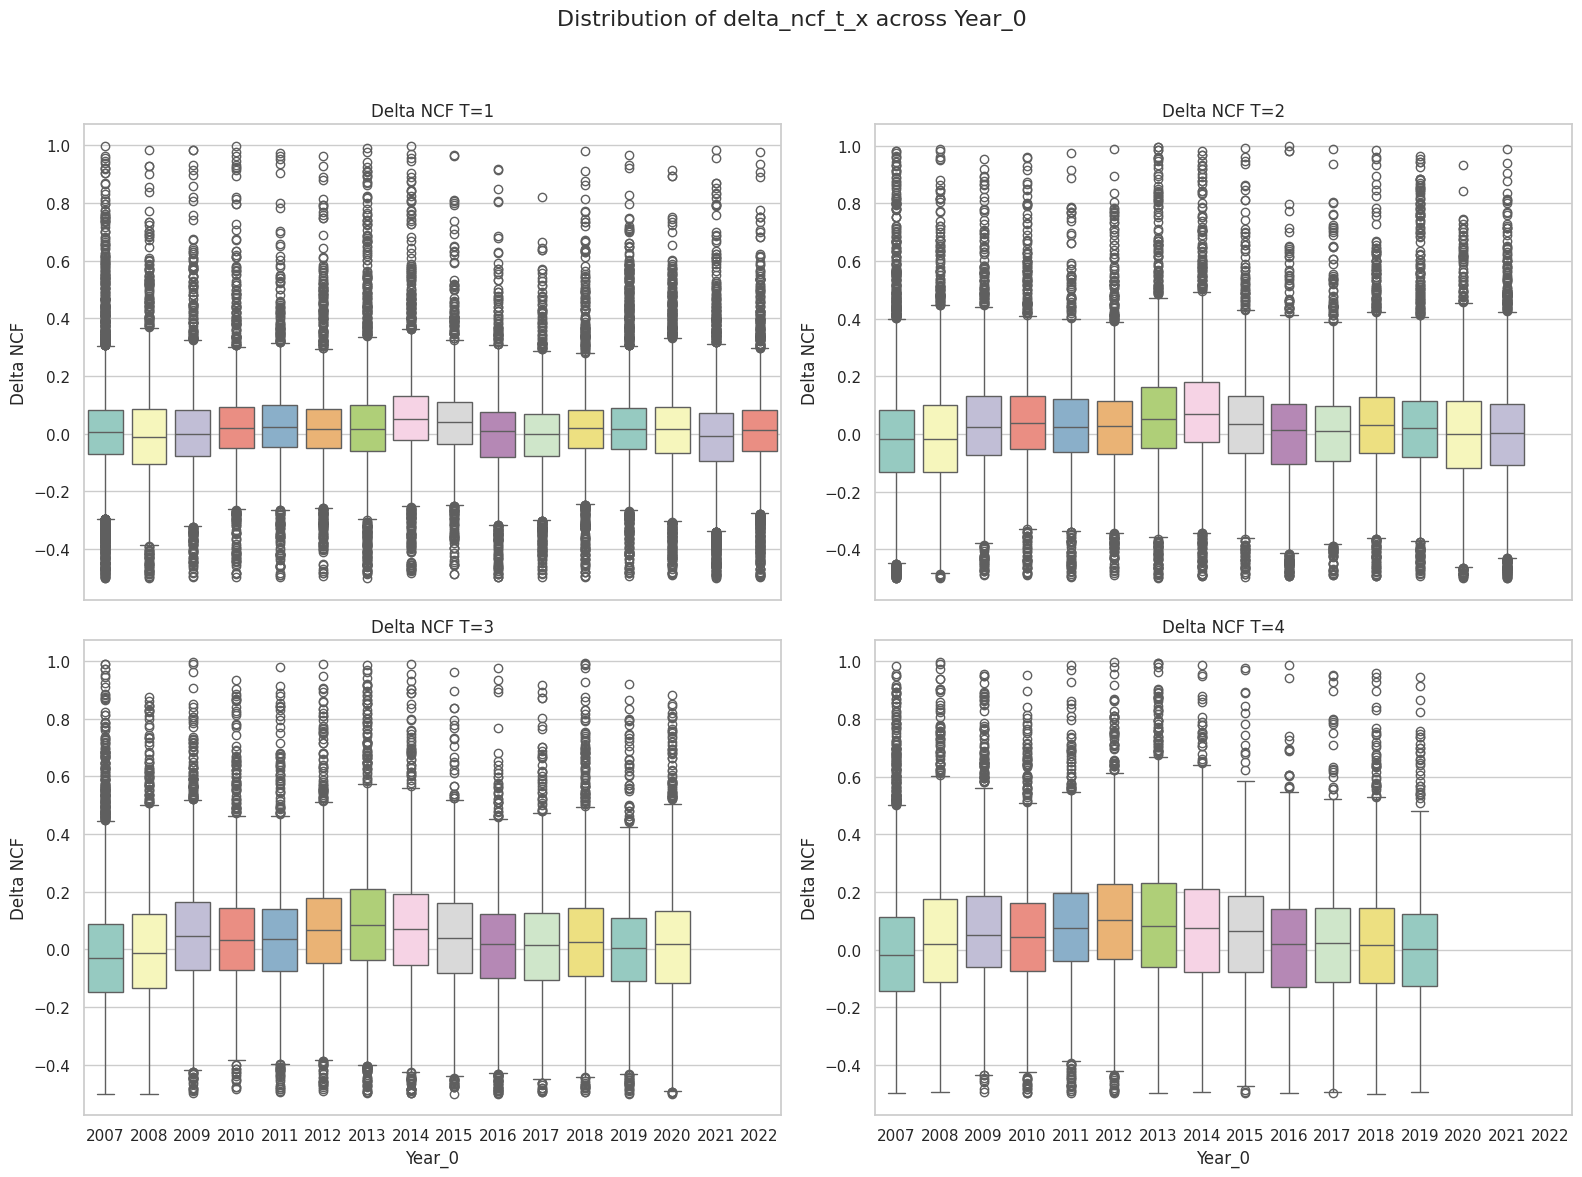

In [8]:

# Set the style for the plots 
sns.set(style="whitegrid")

# Define the figure and axis for subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)
fig.suptitle('Distribution of delta_ncf_t_x across Year_0', fontsize=16)

# List of columns for delta NCF and titles for the subplots
delta_ncf_columns = ['delta_ncf_t_1', 'delta_ncf_t_2', 'delta_ncf_t_3', 'delta_ncf_t_4']
titles = ['Delta NCF T=1', 'Delta NCF T=2', 'Delta NCF T=3', 'Delta NCF T=4']

# Loop through each delta NCF column and plot
for i, (delta_col, title) in enumerate(zip(delta_ncf_columns, titles)):
    ax = axes[i // 2, i % 2]  # Position in the subplot grid
    sns.boxplot(
        data=ncf_change_results_all, 
        x='Year_0', 
        y=delta_col, 
        ax=ax, 
        palette="Set3"
    )
    # Calculate the median across Year_0 for the current delta column
    #median_values = ncf_change_results_all.groupby('Year_0')[delta_col].median()
    
    # Plot the median line
    #ax.plot(median_values.index, median_values.values, color='red', marker='o', linestyle='-', linewidth=1.5, label='Median')
    ax.set_title(title)
    ax.set_xlabel('Year_0')
    ax.set_ylabel('Delta NCF')

# Adjust layout and show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

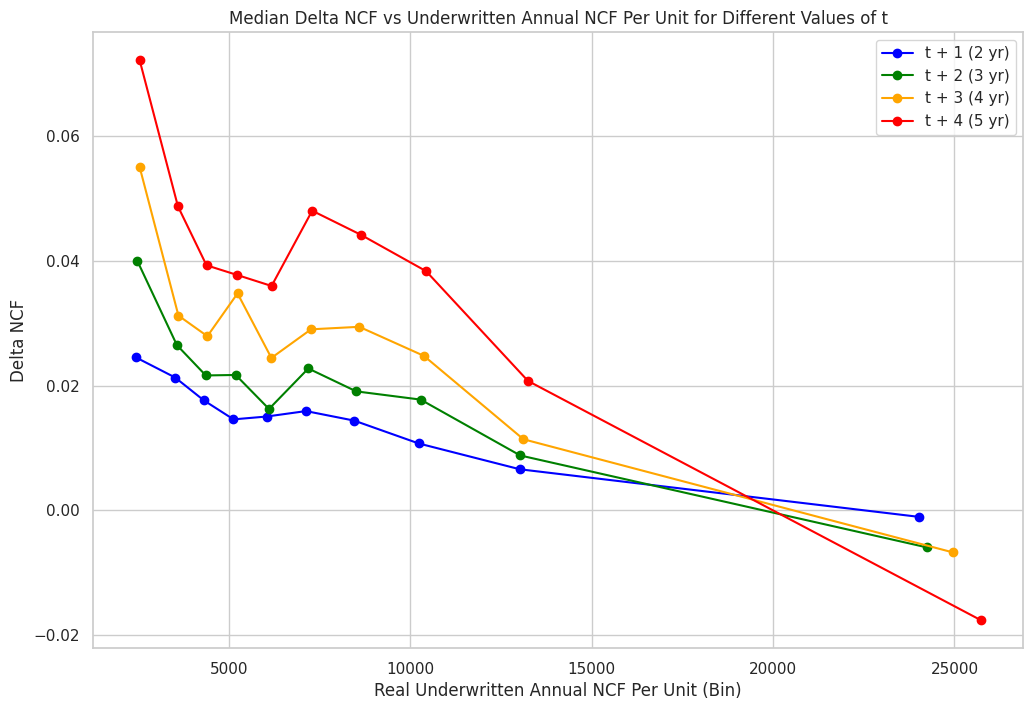

In [9]:
lb = -0.5
ub = 1
# Create bin-scatter plots for each t value
plt.figure(figsize=(12, 8))

# Use different colors and labels for each t value
colors = ['blue', 'green', 'orange', 'red']
for i, t in enumerate(range(1, 5)):
    # Filter the results for the current value of t and drop missing values
    ncf_change_results_t = ncf_change_results_all[['Loan Number', f'delta_ncf_t_{t}', 'Real Underwritten Annual NCF Per Unit']].dropna()
    
    # Apply the filter for delta_ncf between -0.2 and 0.5
    ncf_change_results_t = ncf_change_results_t[(ncf_change_results_t[f'delta_ncf_t_{t}'] >= lb) & 
                                                (ncf_change_results_t[f'delta_ncf_t_{t}'] <= ub)]
    
    # Create bins for the NCF and compute mean delta_ncf for each bin
    ncf_change_results_t['NCF_Bin'], bin_edges = pd.qcut(ncf_change_results_t['Real Underwritten Annual NCF Per Unit'], q=10, retbins=True, duplicates='drop')
    binned_data = ncf_change_results_t.groupby('NCF_Bin').agg({
        'Real Underwritten Annual NCF Per Unit': 'mean',
        f'delta_ncf_t_{t}': 'median'
    }).reset_index()
    
    # Plot the results
    plt.plot(binned_data['Real Underwritten Annual NCF Per Unit'], binned_data[f'delta_ncf_t_{t}'], marker='o', label=f't + {t} ({t+1} yr)', color=colors[i])

# Add labels, title, and legend
plt.xlabel('Real Underwritten Annual NCF Per Unit (Bin)')
plt.ylabel('Delta NCF')
plt.title('Median Delta NCF vs Underwritten Annual NCF Per Unit for Different Values of t')
plt.legend()
plt.grid(True)
plt.show()

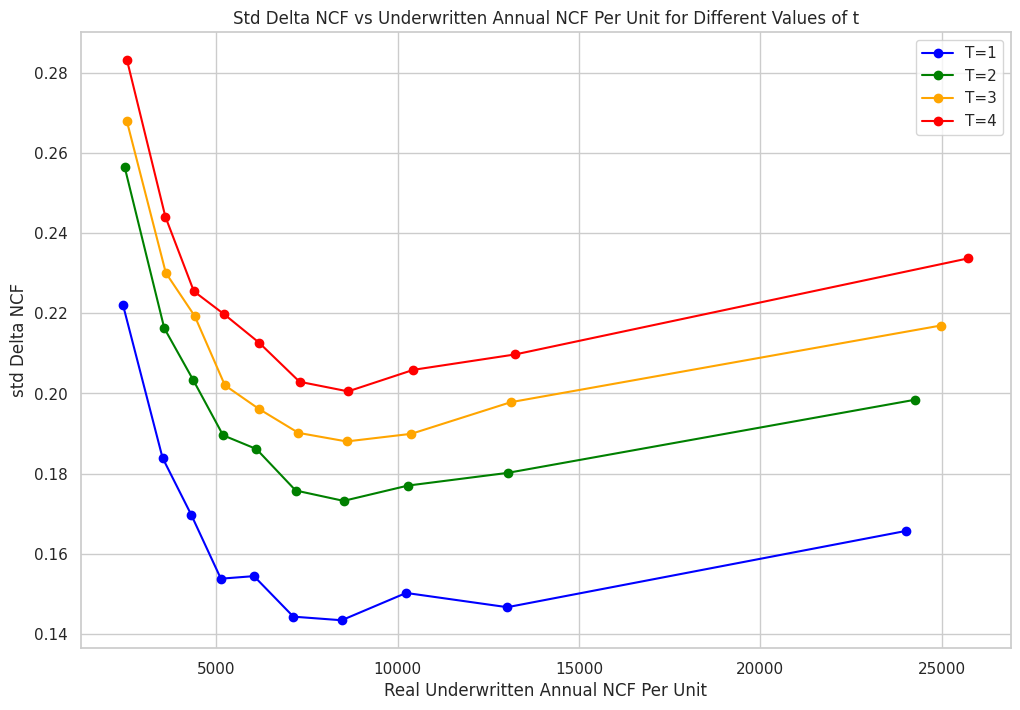

In [10]:
# Create bin-scatter plots for each t value
plt.figure(figsize=(12, 8))

# Use different colors and labels for each t value
colors = ['blue', 'green', 'orange', 'red']
for i, t in enumerate(range(1, 5)):
    # Filter the results for the current value of t and drop missing values
    ncf_change_results_t = ncf_change_results_all[['Loan Number', f'delta_ncf_t_{t}', 'Real Underwritten Annual NCF Per Unit']].dropna()
    
    # Apply the filter for delta_ncf between -0.2 and 0.5
    ncf_change_results_t = ncf_change_results_t[(ncf_change_results_t[f'delta_ncf_t_{t}'] >= lb) & 
                                                (ncf_change_results_t[f'delta_ncf_t_{t}'] <= ub)]
    
    # Create bins for the NCF and compute mean delta_ncf for each bin
    ncf_change_results_t['NCF_Bin'], bin_edges = pd.qcut(ncf_change_results_t['Real Underwritten Annual NCF Per Unit'], q=10, retbins=True, duplicates='drop')
    binned_data = ncf_change_results_t.groupby('NCF_Bin').agg({
        'Real Underwritten Annual NCF Per Unit': 'mean',
        f'delta_ncf_t_{t}': 'std'
    }).reset_index()
    
    # Plot the results
    plt.plot(binned_data['Real Underwritten Annual NCF Per Unit'], binned_data[f'delta_ncf_t_{t}'], marker='o', label= f'T={t}', color=colors[i])

# Add labels, title, and legend
plt.xlabel('Real Underwritten Annual NCF Per Unit')
plt.ylabel('std Delta NCF')
plt.title('Std Delta NCF vs Underwritten Annual NCF Per Unit for Different Values of t')
plt.legend()
plt.grid(True)
plt.show()

## Annualization the Growth Rate

In [11]:
lb = -0.5
ub = 1
ncf_change_results_all_copy = ncf_change_results_all.copy()

for i in range(1,5):
    ncf_change_results_all_copy[f'delta_ncf_t_{i}'] = ((ncf_change_results_all_copy[f'delta_ncf_t_{i}']+1)**(1/i))-1
     # Replace values outside the bounds with NaN
    #ncf_change_results_all_copy[f'delta_ncf_t_{i}'] = ncf_change_results_all_copy[f'delta_ncf_t_{i}'].apply(
        #lambda x: x if lb <= x <= ub else np.nan)

ncf_change_results_all_copy[['delta_ncf_t_1', 'delta_ncf_t_2',
       'delta_ncf_t_3', 'delta_ncf_t_4']].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

,delta_ncf_t_1,delta_ncf_t_2,delta_ncf_t_3,delta_ncf_t_4
count,46185.0000,39700.0000,32331.0000,26045.0000
mean,0.0162,0.0054,0.0052,0.0065
std,0.1654,0.0975,0.0694,0.0550
min,-0.5000,-0.2929,-0.2063,-0.1590
5%,-0.2505,-0.1663,-0.1181,-0.0908
25%,-0.0642,-0.0456,-0.0337,-0.0259
50%,0.0133,0.0085,0.0080,0.0087
75%,0.0882,0.0577,0.0459,0.0405
95%,0.2842,0.1600,0.1158,0.0938
max,0.9979,0.4137,0.2595,0.1890


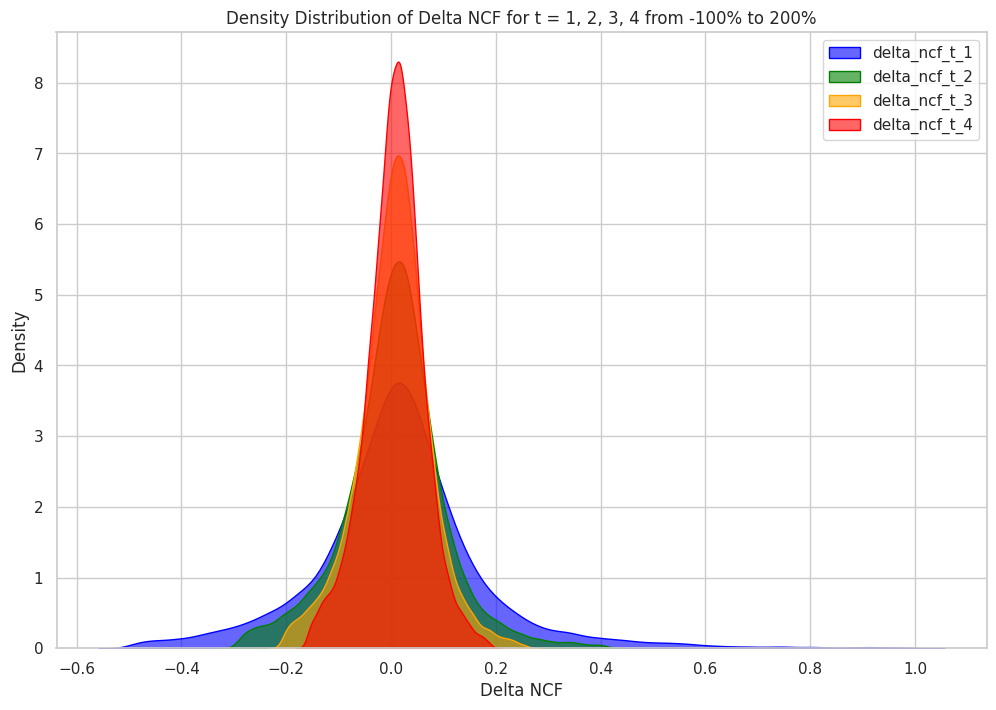

In [12]:
# Filter the data to exclude NaN values for each delta_ncf variable
delta_ncf_t_1 = ncf_change_results_all_copy['delta_ncf_t_1'].dropna()
delta_ncf_t_2 = ncf_change_results_all_copy['delta_ncf_t_2'].dropna()
delta_ncf_t_3 = ncf_change_results_all_copy['delta_ncf_t_3'].dropna()
delta_ncf_t_4 = ncf_change_results_all_copy['delta_ncf_t_4'].dropna()

# Apply the filter for values between -1 and 2
delta_ncf_t_1 = delta_ncf_t_1[(delta_ncf_t_1 >= -0.5) & (delta_ncf_t_1 <= 1)]
delta_ncf_t_2 = delta_ncf_t_2[(delta_ncf_t_2 >= -0.5) & (delta_ncf_t_2 <= 1)]
delta_ncf_t_3 = delta_ncf_t_3[(delta_ncf_t_3 >= -0.5) & (delta_ncf_t_3 <= 1)]
delta_ncf_t_4 = delta_ncf_t_4[(delta_ncf_t_4 >= -0.5) & (delta_ncf_t_4 <= 1)]

# Plot density plots for each t value in a single figure
plt.figure(figsize=(12, 8))

# Density plot for delta_ncf_t_1
sns.kdeplot(delta_ncf_t_1, label='delta_ncf_t_1', color='blue', fill=True, alpha=0.6)

# Density plot for delta_ncf_t_2
sns.kdeplot(delta_ncf_t_2, label='delta_ncf_t_2', color='green', fill=True, alpha=0.6)

# Density plot for delta_ncf_t_3
sns.kdeplot(delta_ncf_t_3, label='delta_ncf_t_3', color='orange', fill=True, alpha=0.6)

# Density plot for delta_ncf_t_4
sns.kdeplot(delta_ncf_t_4, label='delta_ncf_t_4', color='red', fill=True, alpha=0.6)

# Add labels, title, and legend
plt.xlabel('Delta NCF')
plt.ylabel('Density')
plt.title('Density Distribution of Delta NCF for t = 1, 2, 3, 4 from -100% to 200%')
plt.legend()
plt.grid(True)
plt.show()

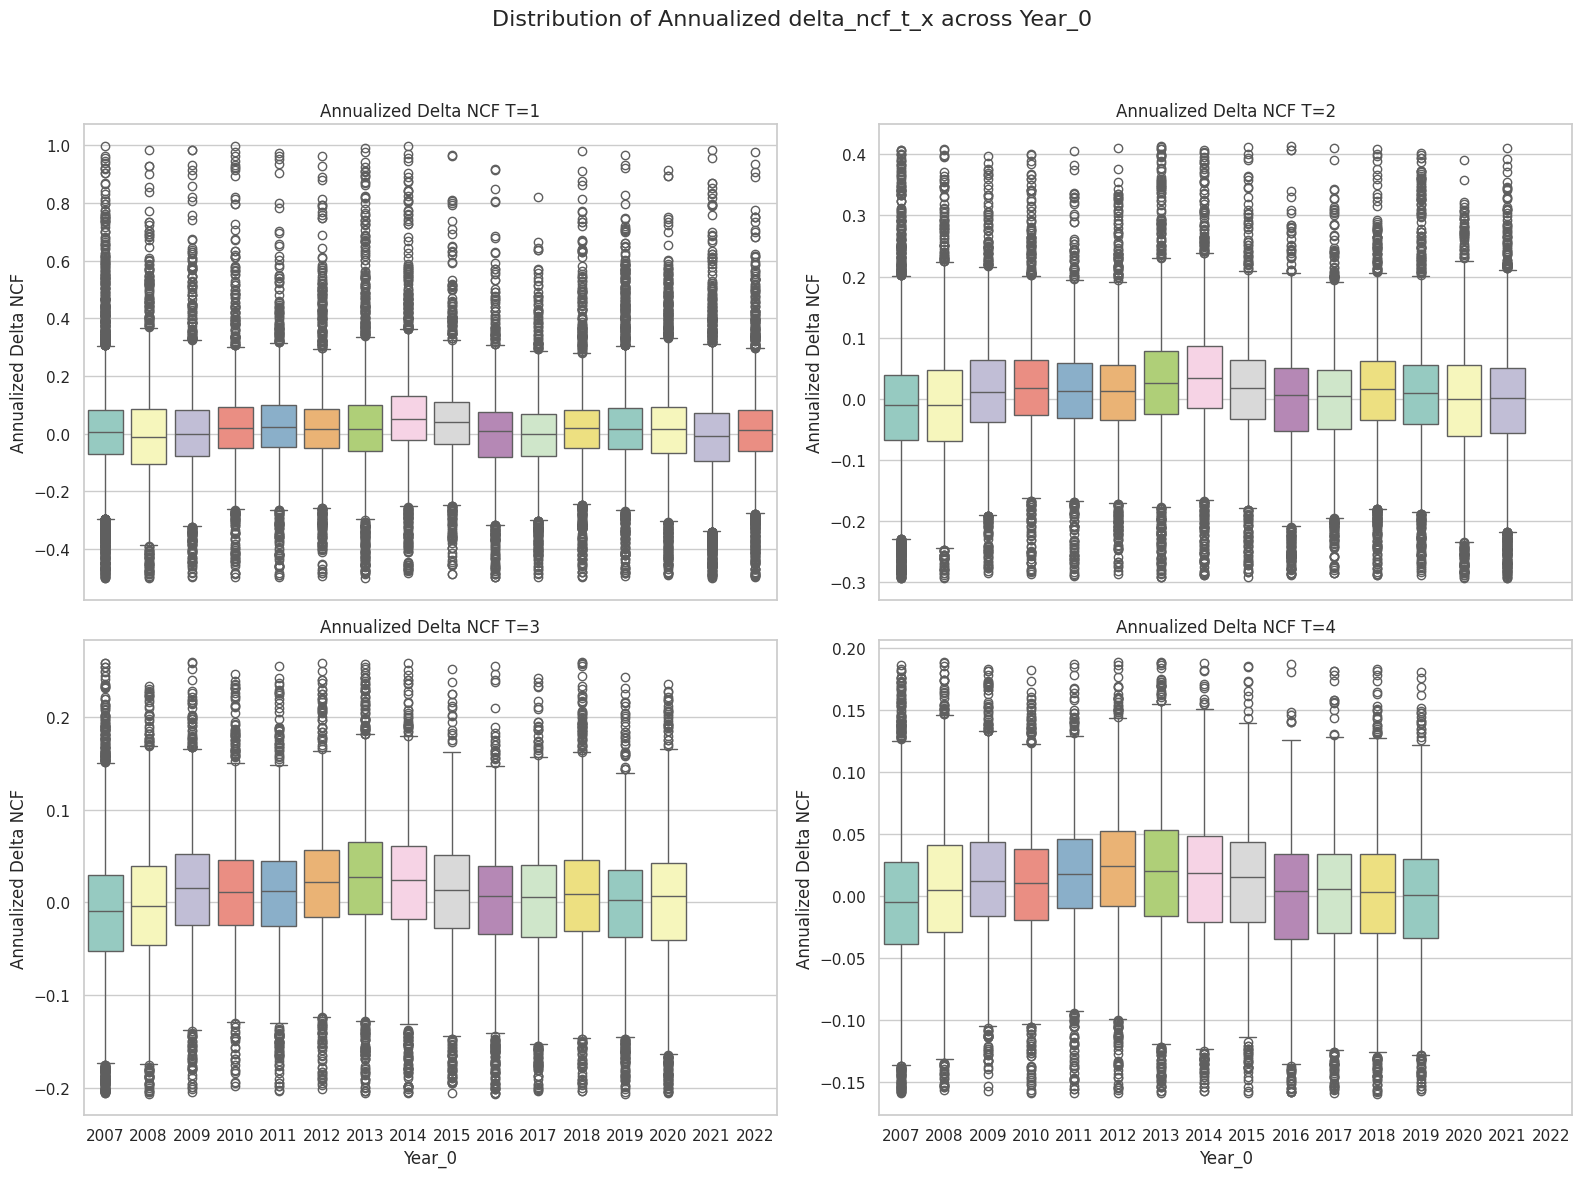

In [13]:
# Set the style for the plots
sns.set(style="whitegrid")

# Define the figure and axis for subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)
fig.suptitle('Distribution of Annualized delta_ncf_t_x across Year_0', fontsize=16)

# List of columns for delta NCF and titles for the subplots
delta_ncf_columns = ['delta_ncf_t_1', 'delta_ncf_t_2', 'delta_ncf_t_3', 'delta_ncf_t_4']
titles = ['Annualized Delta NCF T=1', 'Annualized Delta NCF T=2', 'Annualized Delta NCF T=3', 'Annualized Delta NCF T=4']

# Loop through each delta NCF column and plot
for i, (delta_col, title) in enumerate(zip(delta_ncf_columns, titles)):
    ax = axes[i // 2, i % 2]  # Position in the subplot grid
    sns.boxplot(
        data=ncf_change_results_all_copy, 
        x='Year_0', 
        y=delta_col, 
        ax=ax, 
        palette="Set3"
    )
    ax.set_title(title)
    ax.set_xlabel('Year_0')
    ax.set_ylabel('Annualized Delta NCF')

# Adjust layout and show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

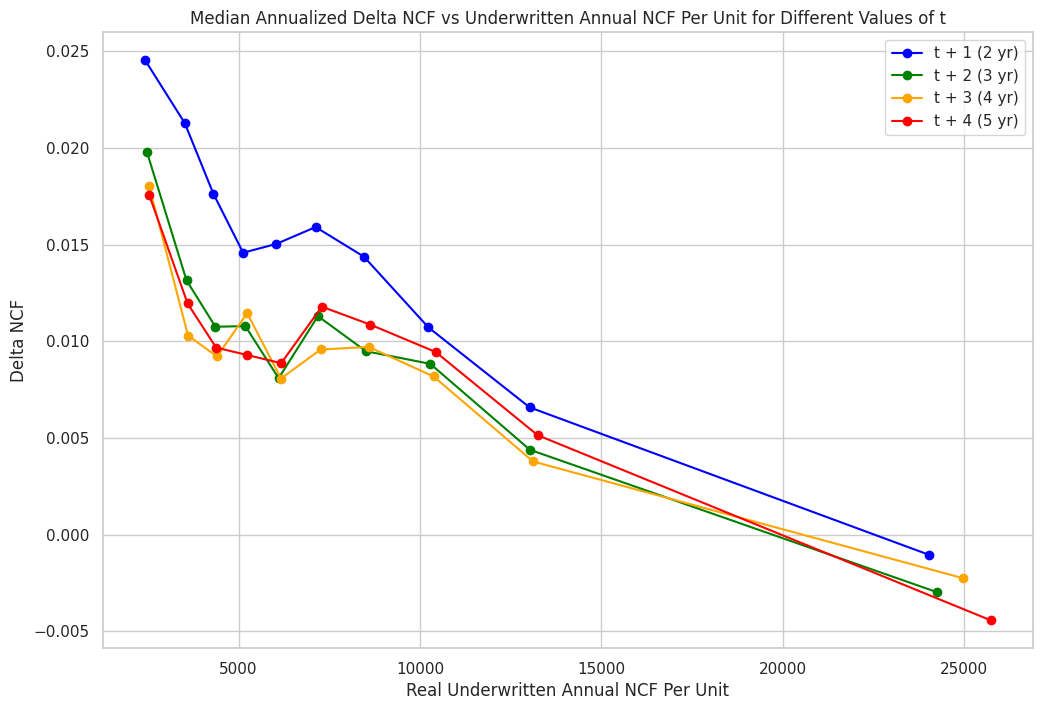

In [14]:
# Create bin-scatter plots for each t value
plt.figure(figsize=(12, 8))

# Use different colors and labels for each t value
colors = ['blue', 'green', 'orange', 'red']
for i, t in enumerate(range(1, 5)):
    # Filter the results for the current value of t and drop missing values
    ncf_change_results_t = ncf_change_results_all_copy[['Loan Number', f'delta_ncf_t_{t}', 'Real Underwritten Annual NCF Per Unit']].dropna()
    
    # Apply the filter for delta_ncf between -0.2 and 0.5
    #ncf_change_results_t = ncf_change_results_t[(ncf_change_results_t[f'delta_ncf_t_{t}'] >= lb) & 
                                                #(ncf_change_results_t[f'delta_ncf_t_{t}'] <= ub)]
    
    # Create bins for the NCF and compute mean delta_ncf for each bin
    ncf_change_results_t['NCF_Bin'], bin_edges = pd.qcut(ncf_change_results_t['Real Underwritten Annual NCF Per Unit'], q=10, retbins=True, duplicates='drop')
    binned_data = ncf_change_results_t.groupby('NCF_Bin').agg({
        'Real Underwritten Annual NCF Per Unit': 'mean',
        f'delta_ncf_t_{t}': 'median'
    }).reset_index()
    
    # Plot the results
    plt.plot(binned_data['Real Underwritten Annual NCF Per Unit'], binned_data[f'delta_ncf_t_{t}'], marker='o', label=f't + {t} ({t+1} yr)', color=colors[i])

# Add labels, title, and legend
plt.xlabel('Real Underwritten Annual NCF Per Unit')
plt.ylabel('Delta NCF')
plt.title('Median Annualized Delta NCF vs Underwritten Annual NCF Per Unit for Different Values of t')
plt.legend()
plt.grid(True)
plt.show()

# NOTE Inforce Figure 21: Median Cash Flow Growth  median_delta_ncf.png

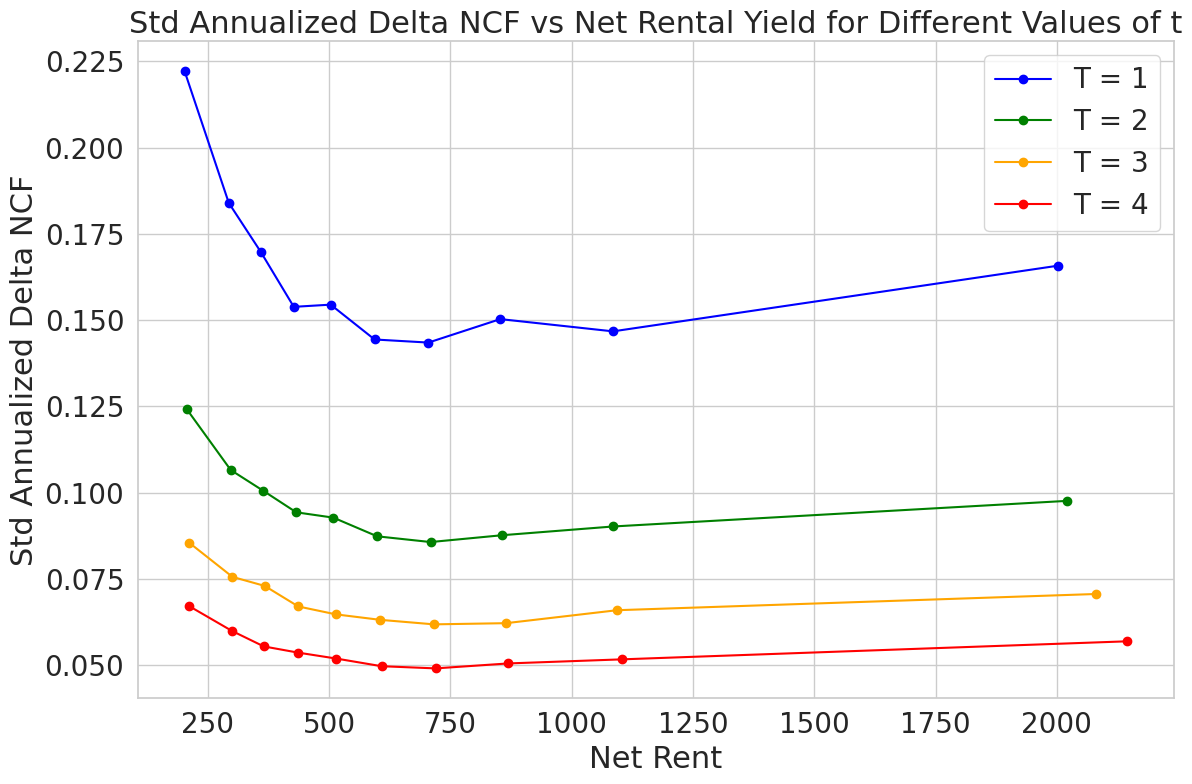

In [29]:
# Create bin-scatter plots for each t value
plt.figure(figsize=(12, 8))

# Use different colors and labels for each t value
colors = ['blue', 'green', 'orange', 'red']
for i, t in enumerate(range(1, 5)):
    # Filter the results for the current value of t and drop missing values
    ncf_change_results_t = ncf_change_results_all_copy[['Loan Number', f'delta_ncf_t_{t}', 'Real Underwritten Annual NCF Per Unit']].dropna()
    
    # Apply the filter for delta_ncf between -0.2 and 0.5
    ncf_change_results_t = ncf_change_results_t[(ncf_change_results_t[f'delta_ncf_t_{t}'] >= lb) & 
                                                (ncf_change_results_t[f'delta_ncf_t_{t}'] <= ub)]
    
    # Create bins for the NCF and compute mean delta_ncf for each bin
    ncf_change_results_t['NCF_Bin'], bin_edges = pd.qcut(ncf_change_results_t['Real Underwritten Annual NCF Per Unit'], q=10, retbins=True, duplicates='drop')
    binned_data = ncf_change_results_t.groupby('NCF_Bin').agg({
        'Real Underwritten Annual NCF Per Unit': 'mean',
        f'delta_ncf_t_{t}': 'std'
    }).reset_index()
    
    # New 240130
    binned_data['Real Underwritten Annual NCF Per Unit']/=12  # Convert to monthly

    # Plot the results
    plt.plot(binned_data['Real Underwritten Annual NCF Per Unit'], binned_data[f'delta_ncf_t_{t}'], marker='o', label=f'T = {t}', color=colors[i])

# Add labels, title, and legend
# New formats 240130
plt.xlabel('Net Rent', fontsize=22)
plt.ylabel('Std Annualized Delta NCF', fontsize=22)
plt.title('Std Annualized Delta NCF vs Net Rental Yield for Different Values of t', fontsize=22)
plt.legend(fontsize=20, title_fontsize=20)
plt.tick_params(axis='both', labelsize=20)  # Increase font size for both x and y ticks


# plt.xlabel('Real Underwritten Annual NCF Per Unit')
# plt.ylabel('std Annualized Delta NCF')
# plt.title('Std Annualized Delta NCF vs Real Underwritten Annual NCF Per Unit for Different Values of t')
# plt.legend()

plt.grid(True)
plt.tight_layout()

plt.savefig('Figures/Std_delta.png')

plt.show()


# NOTE: Inforce Std_delta.png Figure 15: Cash Flow Growth Volatility

In [16]:
rps = pd.read_csv('all_rps.csv')
# Create a mapping dictionary for state names to their two-letter abbreviations
state_abbreviation_mapping = {
    'california': 'CA', 'oregon': 'OR', 'new-york': 'NY', 'vermont': 'VT', 'washington-dc': 'DC',
    'maryland': 'MD', 'maine': 'ME', 'delaware': 'DE', 'colorado': 'CO', 'connecticut': 'CT',
    'new-jersey': 'NJ', 'massachusetts': 'MA', 'hawaii': 'HI', 'washington': 'WA', 'rhode-island': 'RI',
    'pennsylvania': 'PA', 'michigan': 'MI', 'iowa': 'IA', 'nebraska': 'NE', 'nevada': 'NV',
    'new-hampshire': 'NH', 'alaska': 'AK', 'montana': 'MT', 'north-carolina': 'NC', 'virginia': 'VA',
    'new-mexico': 'NM', 'florida': 'FL', 'illinois': 'IL', 'north-dakota': 'ND', 'arizona': 'AZ',
    'utah': 'UT', 'wisconsin': 'WI', 'georgia': 'GA', 'kansas': 'KS', 'texas': 'TX',
    'idaho': 'ID', 'indiana': 'IN', 'ohio': 'OH', 'south-carolina': 'SC', 'missouri': 'MO',
    'kentucky': 'KY', 'south-dakota': 'SD', 'louisiana': 'LA', 'tennessee': 'TN', 'west-virginia': 'WV',
    'arkansas': 'AR', 'wyoming': 'WY', 'mississippi': 'MS', 'alabama': 'AL', 'oklahoma': 'OK','minnesota':'MN'}

# Apply the mapping to the State column
rps['State'] = rps['State'].map(state_abbreviation_mapping)

In [17]:
std_delta_ncf_t_1_state = ncf_change_results_all_copy[['Loan Number','delta_ncf_t_1']].merge(annual_performance[['Loan Number','Property State']].drop_duplicates(),on='Loan Number',how='left').dropna().groupby('Property State')['delta_ncf_t_1'].std().sort_values().reset_index()

In [18]:
rps = rps.merge(std_delta_ncf_t_1_state,left_on='State',right_on='Property State',how='left')

In [19]:
rps

,State,4o-mini RPS Score,o1-mini RPS Score,Claude RPS Score,Gemeni RPS Score,Milcheva RPS,4o-mini RPS Rank,o1-mini RPS Rank,Claude RPS Rank,Gemeni RPS Rank,Milcheva RPS Rank,Property State,delta_ncf_t_1
0,CA,30,28,26,23,17,1,1,4,4,12,CA,0.1393
1,OR,30,28,24,22,18,1,1,7,5,7,OR,0.1445
2,MN,21,26,26,17,15,11,3,4,32,20,MN,0.1382
3,NY,30,26,30,24,11,1,3,1,2,33,NY,0.2364
4,VT,22,26,24,17,22,7,3,7,32,1,VT,0.1042
5,DC,29,26,26,28,17,4,3,4,1,12,DC,0.1549
6,MD,19,24,28,24,12,19,7,3,2,30,MD,0.1536
7,ME,21,23,18,19,17,11,8,21,13,12,ME,0.1610
8,DE,20,23,16,20,21,16,8,32,8,2,DE,0.1365
9,CO,20,23,17,19,7,16,8,28,13,43,CO,0.1548


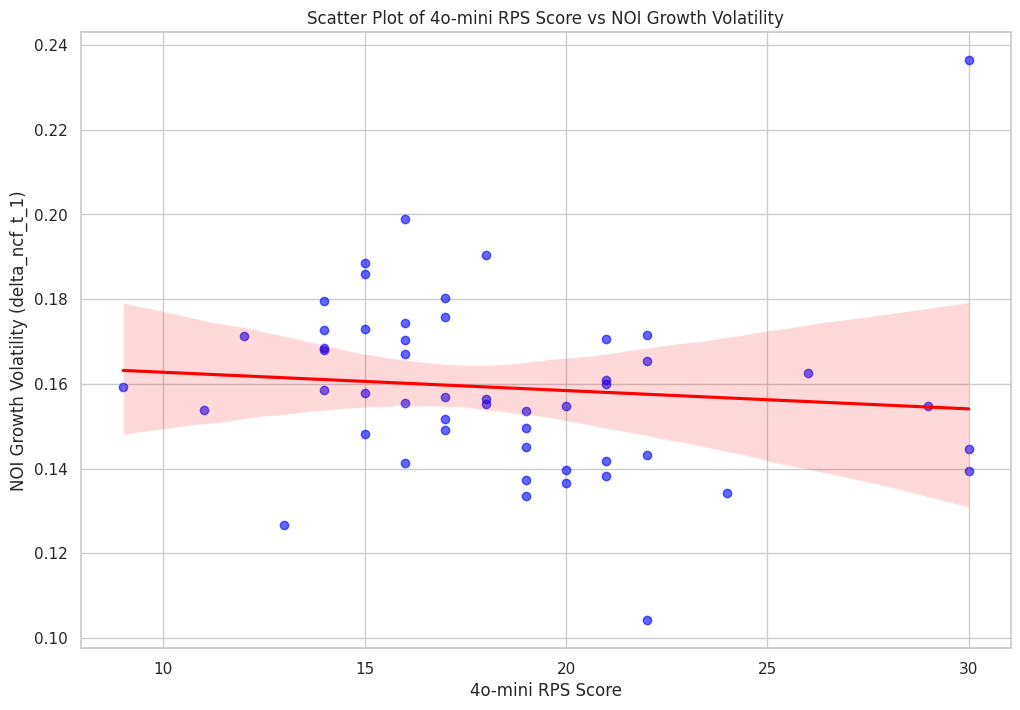

In [20]:
plt.figure(figsize=(12, 8))

# Scatter plot of GPT RPS score against NOI growth volatility (delta_ncf_t_1)
sns.regplot(x='4o-mini RPS Score', y='delta_ncf_t_1', data=rps, scatter_kws={'color': 'blue', 'alpha': 0.6}, line_kws={'color': 'red'})

# Add labels and title
plt.xlabel('4o-mini RPS Score')
plt.ylabel('NOI Growth Volatility (delta_ncf_t_1)')
plt.title('Scatter Plot of 4o-mini RPS Score vs NOI Growth Volatility')

# Show the plot
plt.grid(True)
plt.show()

# NOTE: Inforce Figure 24: Comparing Our RPS to Other Tenant Risk Metrics    gpt_vs_deli.png

## TS Median Growth Overtime by NCF Bin

In [21]:
# Real GDP Growth Data
gdp_growth = {
    'Growth Year': [ 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'GDP Growth': [ 0.11358, -2.5765, 2.69519, 1.56441, 2.28911, 2.11783, 2.52382, 2.94555, 1.81945, 2.45762, 2.9665, 2.58383, -2.16303, 6.05506, 2.51238, 2.88755]
}


# Convert to DataFrame
gdp_growth_df = pd.DataFrame(gdp_growth)

gdp_growth_df['GDP Growth'] = gdp_growth_df['GDP Growth']/100

In [22]:
# Compute the Deciles
ncf_deciles = mortgage_activity[['Loan Number', 'Real Underwritten Annual NCF Per Unit']].drop_duplicates()

# Create NCF_Bin as deciles (1 to 10)
ncf_deciles['NCF_Bin'], edges = pd.qcut(
    ncf_deciles['Real Underwritten Annual NCF Per Unit'], 
    q=10,  # Deciles (10 equal-sized bins)
    labels=range(1, 11),  # Label the deciles as 1 to 10
    retbins=True,  # Also return the edges of the bins
    duplicates='drop'  # Drop duplicate bin edges if any
)

# Sort the data by Loan Number and Year to ensure calculations happen in sequence
annual_performance_sorted = annual_performance.sort_values(by=['Loan Number', 'Year'])
annual_performance_sorted = annual_performance_sorted.merge(ncf_deciles[['Loan Number','NCF_Bin']].drop_duplicates(),on='Loan Number',how='left')

In [23]:
# Function to compute the delta NCF Growth for each Loan Number
def compute_delta_ncf_growth(group):
    n = len(group)
    delta_ncf_growth_list = []
    growth_year_list = []
    
    # Iterate through each pair of consecutive years
    for i in range(n - 1):
        NCF_t = group['Real Annual NCF Per Unit'].iloc[i]
        NCF_t_plus_1 = group['Real Annual NCF Per Unit'].iloc[i + 1]
        
        # Apply the formula for delta NCF Growth
        if NCF_t_plus_1 + NCF_t != 0:  # Avoid division by zero
            delta_ncf_growth = (NCF_t_plus_1 - NCF_t) / (0.5 * (NCF_t_plus_1 + NCF_t))
        else:
            delta_ncf_growth = None
        
        delta_ncf_growth_list.append(delta_ncf_growth)
        growth_year_list.append(group['Year'].iloc[i + 1])  # The growth year corresponds to the second year in the pair
    
    # Return both the delta NCF growth and the corresponding year
    return pd.DataFrame({
        'Year delta_NCF Growth': delta_ncf_growth_list,
        'Growth Year': growth_year_list
    }, index=group.index[:-1])

# Apply the function to each Loan Number group
ncf_growth_results = annual_performance_sorted.groupby('Loan Number').apply(compute_delta_ncf_growth).reset_index()

# Merge with the original DataFrame to include the NCF_Bin
ncf_growth_results = ncf_growth_results.merge(
    annual_performance_sorted[['Loan Number', 'Year', 'NCF_Bin']],
    left_on=['Loan Number', 'Growth Year'], right_on=['Loan Number', 'Year'],
    how='left'
)

In [24]:
ncf_growth_results.dropna(inplace=True)

In [25]:
# Define conditions for mapping NCF_Bin values to new groups
conditions = [
    (ncf_growth_results['NCF_Bin'] == 1) | (ncf_growth_results['NCF_Bin'] == 2),
    (ncf_growth_results['NCF_Bin'] == 3) | (ncf_growth_results['NCF_Bin'] == 4),
    (ncf_growth_results['NCF_Bin'] == 5) | (ncf_growth_results['NCF_Bin'] == 6),
    (ncf_growth_results['NCF_Bin'] == 7) | (ncf_growth_results['NCF_Bin'] == 8),
    (ncf_growth_results['NCF_Bin'] == 9) | (ncf_growth_results['NCF_Bin'] == 10)
]

# Define the values to assign for each condition
values = [1, 2, 3, 4, 5]

# Create a new column 'NCF_Bin_Grouped' based on the conditions and values
ncf_growth_results['NCF_Bin_Grouped'] = np.select(conditions, values)

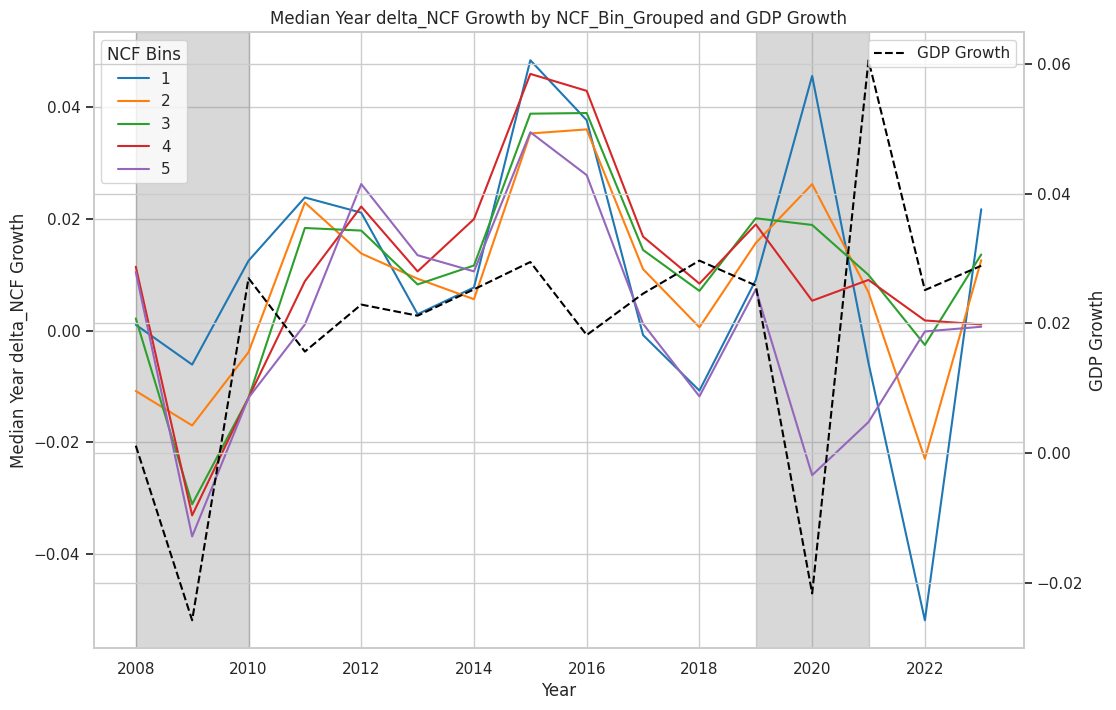

In [26]:
 # Group the NCF growth results by 'Growth Year' and 'NCF_Bin_Grouped' and calculate the median 'Year delta_NCF Growth'
ncf_median_growth = ncf_growth_results.groupby(['Growth Year', 'NCF_Bin_Grouped'])['Year delta_NCF Growth'].median().unstack()

# Set the seaborn style
sns.set(style="whitegrid")

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Use seaborn to plot the median NCF growth for each NCF_Bin_Grouped
sns.lineplot(data=ncf_median_growth, ax=ax1, palette="tab10", dashes=False)

# Set the labels for the first y-axis (left)
ax1.set_xlabel('Year')
ax1.set_ylabel('Median Year delta_NCF Growth')

# Create a second y-axis for the GDP growth
ax2 = ax1.twinx()

# Plot the GDP growth on the second y-axis using seaborn for consistency
sns.lineplot(x=gdp_growth_df['Growth Year'], y=gdp_growth_df['GDP Growth'], ax=ax2, color='black', linestyle='--', label='GDP Growth')

# Set the label for the second y-axis (right)
ax2.set_ylabel('GDP Growth')

# Highlight the periods 2008-2010 and 2019-2021
ax1.axvspan(2008, 2010, color='gray', alpha=0.3)
ax1.axvspan(2019, 2021, color='gray', alpha=0.3)

# Add legends for both axes
ax1.legend(loc='upper left', title='NCF Bins')
ax2.legend(loc='upper right')

# Set the title
plt.title('Median Year delta_NCF Growth by NCF_Bin_Grouped and GDP Growth')

# Show the plot
plt.show()

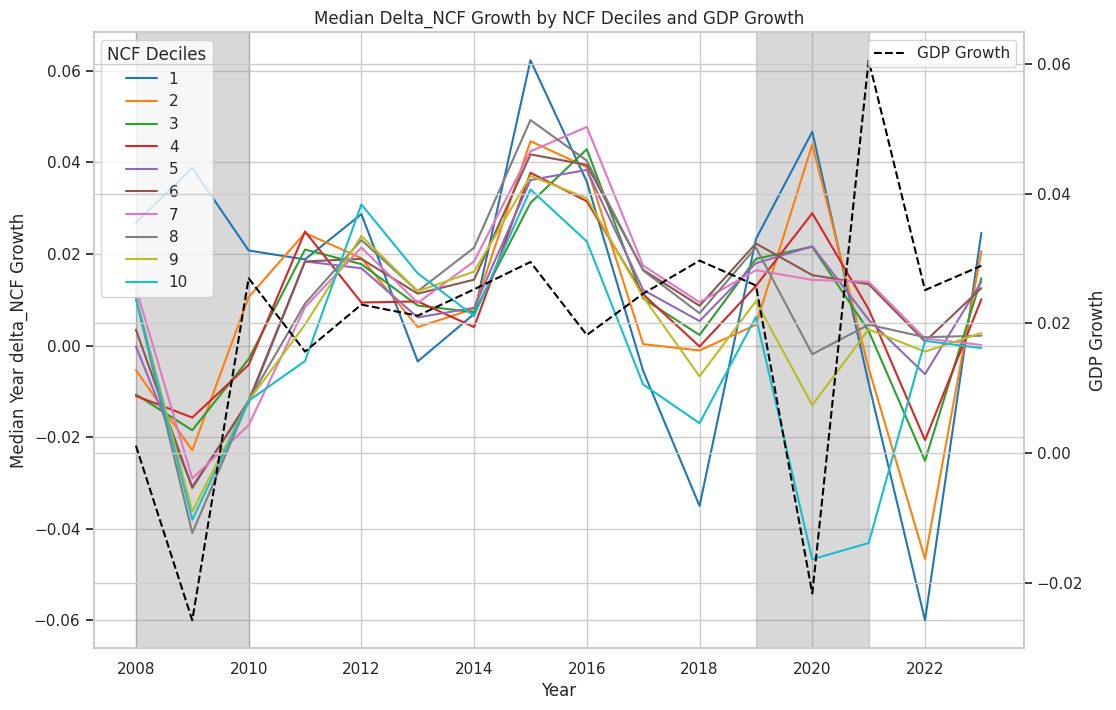

In [27]:
# Group the NCF growth results by 'Growth Year' and 'NCF_Bin_Grouped' and calculate the median 'Year delta_NCF Growth'
ncf_median_growth = ncf_growth_results.groupby(['Growth Year', 'NCF_Bin'])['Year delta_NCF Growth'].median().unstack()

# Set the seaborn style
sns.set(style="whitegrid")

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Use seaborn to plot the median NCF growth for each NCF_Bin_Grouped
sns.lineplot(data=ncf_median_growth, ax=ax1, palette="tab10", dashes=False)

# Set the labels for the first y-axis (left)
ax1.set_xlabel('Year')
ax1.set_ylabel('Median Year delta_NCF Growth')

# Create a second y-axis for the GDP growth
ax2 = ax1.twinx()

# Plot the GDP growth on the second y-axis using seaborn for consistency
sns.lineplot(x=gdp_growth_df['Growth Year'], y=gdp_growth_df['GDP Growth'], ax=ax2, color='black', linestyle='--', label='GDP Growth')

# Set the label for the second y-axis (right)
ax2.set_ylabel('GDP Growth')

# Highlight the periods 2008-2010 and 2019-2021
ax1.axvspan(2008, 2010, color='gray', alpha=0.3)
ax1.axvspan(2019, 2021, color='gray', alpha=0.3)

# Add legends for both axes
ax1.legend(loc='upper left', title='NCF Deciles')
ax2.legend(loc='upper right')

# Set the title
plt.title('Median Delta_NCF Growth by NCF Deciles and GDP Growth')

# Show the plot
plt.show()

# NOTE: Inforce Figure 16: Covariance of Cash Flow Growth With GDP Growth   Median_NCF_Growth.png

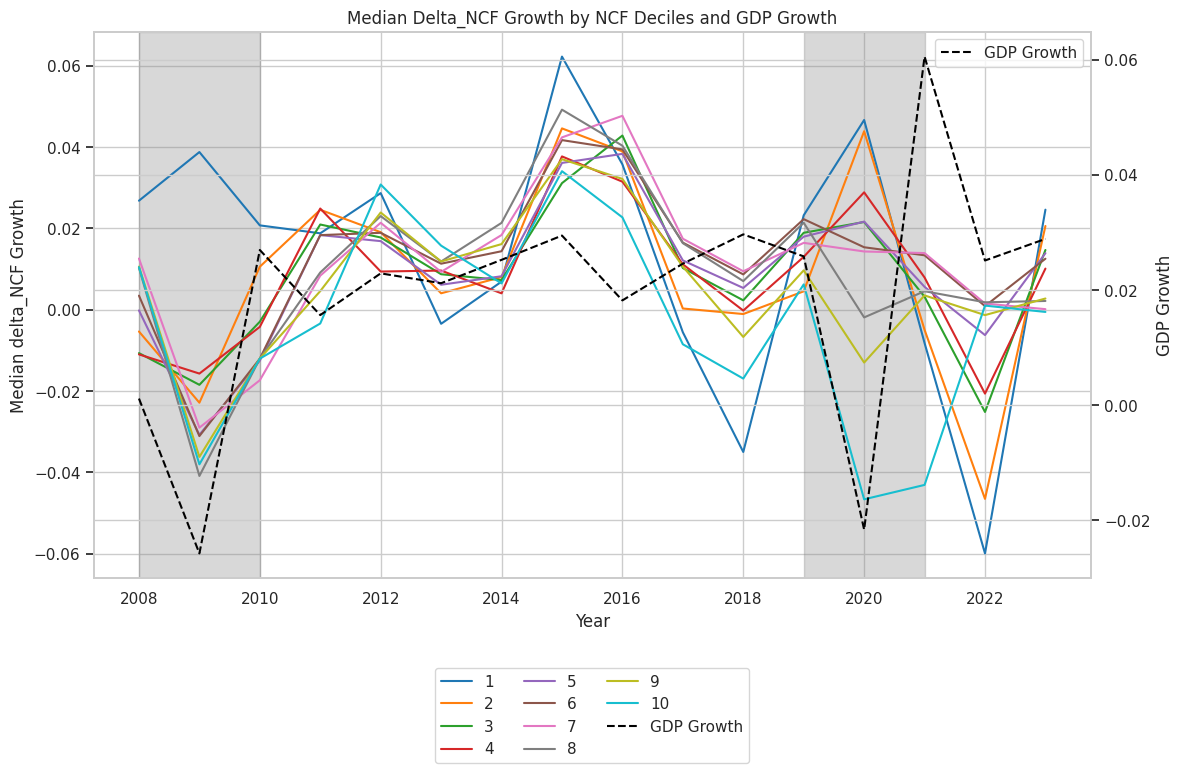

In [28]:
# Group the NCF growth results by 'Growth Year' and 'NCF_Bin_Grouped' and calculate the median 'Year delta_NCF Growth'
ncf_median_growth = ncf_growth_results.groupby(['Growth Year', 'NCF_Bin'])['Year delta_NCF Growth'].median().unstack()

# Set the seaborn style
sns.set(style="whitegrid")

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Use seaborn to plot the median NCF growth for each NCF_Bin_Grouped
sns.lineplot(data=ncf_median_growth, ax=ax1, palette="tab10", dashes=False)

# Set the labels for the first y-axis (left)
ax1.set_xlabel('Year')
ax1.set_ylabel('Median delta_NCF Growth')

# Create a second y-axis for the GDP growth
ax2 = ax1.twinx()

# Plot the GDP growth on the second y-axis using seaborn for consistency
sns.lineplot(x=gdp_growth_df['Growth Year'], y=gdp_growth_df['GDP Growth'], ax=ax2, color='black', linestyle='--', label='GDP Growth')

# Set the label for the second y-axis (right)
ax2.set_ylabel('GDP Growth')

# Highlight the periods 2008-2010 and 2019-2021
ax1.axvspan(2008, 2010, color='gray', alpha=0.3)
ax1.axvspan(2019, 2021, color='gray', alpha=0.3)

# Add legends for both axes at the bottom
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Set the title
plt.title('Median Delta_NCF Growth by NCF Deciles and GDP Growth')

# Show the plot
plt.tight_layout()
plt.show()
